### Importar librerías y series de datos

In [1]:
#importar datos y librerias
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy import special
#leer excel de datos y de dias especiales
general = pd.read_excel (r'C:\Users\Diana\PAP\Data\Data1.xlsx')
special_days= pd.read_excel (r'C:\Users\Diana\PAP\Data\Christmas.xlsx')
#convertir dias especiales a fechas en python
for column in special_days.columns:
    special_days[column] = pd.to_datetime(special_days[column])
general = general.set_index('fecha')

### Establecer las funciones a utilizar

In [2]:
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    x=0
    data1_kron=data1[x:x+1]
    data2_kron=data2[x:x+1]
    Combinacion=np.kron(data1_kron,data2_kron)
    Combinacion=pd.DataFrame(Combinacion)
    for x in range(1,len(data1)):
        data1_kron=data1[x:x+1]
        data2_kron=data2[x:x+1]
        kron=np.kron(data1_kron,data2_kron)
        Kron=pd.DataFrame(kron)
        Combinacion=Combinacion.append(Kron)
    return Combinacion

In [3]:
def regresion_linear(X:'variables para regresion',y:'datos'):
    global model
    model.fit(X, y)
    coefficients=model.coef_
    return model.predict(X)

### Hacer variables dummies

In [4]:
n=-5
final=general.MWh.tail(-n)
onlyMWh=pd.DataFrame(general.MWh)
onlyMWh=onlyMWh.head(5400)
general=general.head(5400)
general['Month'] = general.index.month
general['Weekday_Name'] = general.index.weekday_name
dates=general.index
dummies = pd.get_dummies(general['Weekday_Name']).astype(int)
dummies2 = pd.get_dummies(general['Month']).astype(int)
Dum=pd.DataFrame(dummies.join(dummies2))
t=np.arange(0,len(onlyMWh))
Dum["t"]= np.arange(0,len(onlyMWh))
Dum["tiempo"]= np.arange(1,len(onlyMWh)+1)
Dum["ones"]=np.ones(len(t))
Dum= Dum.set_index('t')

In [5]:
Dum["Dom santo"]=0
Dum["NewYear"]=0
Dum["Constitucion"]=0
Dum["Benito"]=0
Dum["Jue santo"]=0
Dum["Vie santo"]=0
Dum["Trabajo"]=0
Dum["Madre"]=0
Dum["Grito"]=0
Dum["virgen"]=0
Dum["muertos"]=0
Dum["Virgen2"]=0
Dum["Navidad"]=0
Dum["elecciones"]=0
Dum["toma"]=0
Dum["sab santo"]=0
Dum["rev"]=0

ind=0 
for date in general.index:
    for date2 in special_days["Dom santo"]:
        if date ==date2:
            Dum.iloc[ind,21]=1
    for date2 in special_days["NewYear"]:
        if date ==date2:
            Dum.iloc[ind,22]=1
    for date2 in special_days["Constitucion"]:
        if date ==date2:
            Dum.iloc[ind,23]=1
    for date2 in special_days["Benito"]:
        if date ==date2:
            Dum.iloc[ind,24]=1
    for date2 in special_days["Jue santo"]:
        if date ==date2:
            Dum.iloc[ind,25]=1
    for date2 in special_days["Vie santo"]:
        if date ==date2:
            Dum.iloc[ind,26]=1
    for date2 in special_days["Trabajo"]:
        if date ==date2:
            Dum.iloc[ind,27]=1
    for date2 in special_days["Madre"]:
        if date ==date2:
            Dum.iloc[ind,28]=1
    for date2 in special_days["virgen"]:
        if date ==date2:
            Dum.iloc[ind,29]=1
    for date2 in special_days["muertos"]:
        if date ==date2:
            Dum.iloc[ind,30]=1
    for date2 in special_days["Virgen2"]:
        if date ==date2:
            Dum.iloc[ind,31]=1
    for date2 in special_days["Navidad"]:
        if date ==date2:
            Dum.iloc[ind,32]=1
    for date2 in special_days["elecciones"]:
        if date ==date2:
            Dum.iloc[ind,33]=1
    for date2 in special_days["toma"]:
        if date ==date2:
            Dum.iloc[ind,34]=1
    for date2 in special_days["sab santo"]:
        if date ==date2:
            Dum.iloc[ind,35]=1
    for date2 in special_days["rev"]:
        if date ==date2:
            Dum.iloc[ind,35]=1
    ind+=1
del Dum["Friday"]
Dum.drop(Dum.columns[[15]], axis=1,inplace=True)

### Observar descomposición

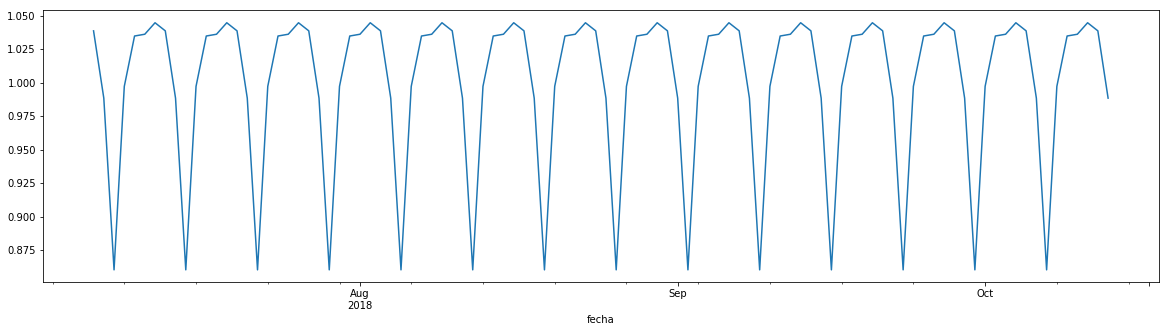

In [6]:
part=final=general.MWh.tail(100)
result=seasonal_decompose(part, model='multiplicative')
fig = result.seasonal.plot(figsize=(20,5))

Al ver la decomposición, se puede ver por la forma que fourier debe estblecerse en senos y cosenos absolutos, para que se parezca a la estacionalidad de la serie. Se agrega a las variables dummies esta estacionalidad semanal, que parece ser fundamental en los datos

### Detectar efecto de las variables dummies

In [7]:
t=np.arange(1,len(onlyMWh)+1)
Tiempo=pd.DataFrame(t)
Tiempo["one"]=np.ones(len(onlyMWh))
Dum['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
Dum['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
Combinacion=kronecker(Dum,Tiempo)

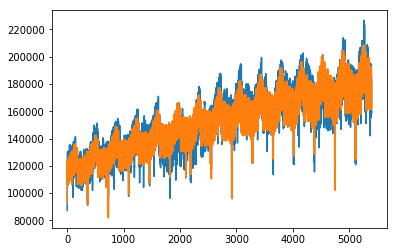

3.570747684529189


In [9]:
model = LinearRegression()
prediction=regresion_linear(Combinacion[:n],general.MWh.values[:n])
plt.plot(onlyMWh.MWh.values[:n])
plt.plot(prediction)
#plt.axis([1630,1650,120000,160000])
plt.show()
comparacion=pd.DataFrame(columns=['real','prediccion','error'])
comparacion.real=onlyMWh.MWh.values[:n]
comparacion.prediccion=prediction
comparacion.error=np.abs((comparacion.real-comparacion.prediccion)/comparacion.real)
MAPE=comparacion.error.mean()*100
print(MAPE)

### Obtener error de datos con variables dummies vs datos reales

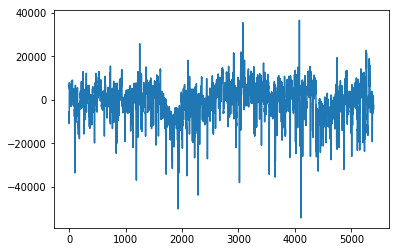

In [10]:
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=prediction
Tabla["datos"]=onlyMWh.MWh.values[:n]
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

### Establecer las frecuencias que se debe considerar en la serie de fourier

C:\Users\Diana\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


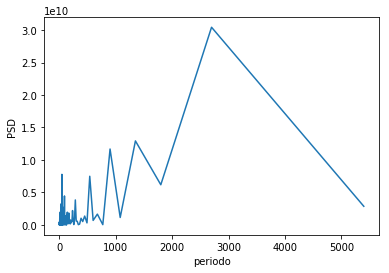

In [11]:
f, Pxx_den = signal.periodogram(Tabla.resta, 1)
plt.plot(1/f, Pxx_den)
plt.xlabel('periodo')
plt.ylabel('PSD')
plt.show()

In [12]:
top_50_periods = {}
# get indices for 3 highest Pxx values
top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[2:10]

freqs = f[top50_freq_indices]
power = Pxx_den[top50_freq_indices]
periods = 1 / np.array(freqs)
matrix=pd.DataFrame(columns=["power","periods"])
matrix.power=power
matrix.periods=periods
print(matrix)

          power      periods
0  1.168246e+10   899.166667
1  7.784001e+09    45.720339
2  7.488703e+09   539.500000
3  6.182408e+09  1798.333333
4  4.456689e+09    91.440678
5  3.843654e+09   283.947368
6  3.214956e+09    26.062802
7  2.950692e+09    36.452703


### Hacer la regresión del efecto cruzado de variables dummies y senos/cosenos absolutos de frecuencia de error

In [14]:
sencos = pd.DataFrame()
sencos["t"]=np.arange(1,len(onlyMWh)+1)
for i  in  matrix.periods:
        sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/i)*t))
        sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/i)*t))
sencos["unos"] = 1

In [15]:
sencos_test=sencos[n:]
sencos_train=sencos[0:n]
Dum_test=Dum[n:]
Dum_train=Dum[0:n]
Combinacion=kronecker(Dum_train,sencos_train)

In [17]:
model = LinearRegression()
prediction=regresion_linear(Combinacion,general.MWh.values[0:n])

### MAPE de la regresion

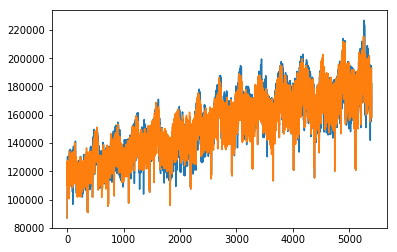

2.5907690563828245


In [18]:
plt.plot(onlyMWh.MWh[0:n].values)
plt.plot(prediction)
#plt.axis([1630,1650,120000,160000])
plt.show()
#%%obtener mape de regresión
comparacion=pd.DataFrame(columns=['real','prediccion','error'])
comparacion.real=onlyMWh.MWh[0:n].values
comparacion.prediccion=prediction
comparacion.error=np.abs((comparacion.real.values-comparacion.prediccion)/comparacion.real)
MAPE=comparacion.error.mean()*100
print(MAPE)

### Graficar residuales de la regresión

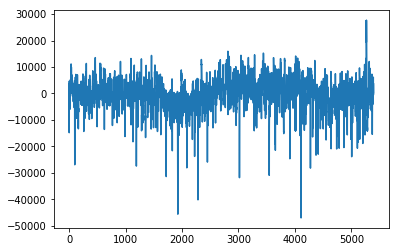

In [19]:
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=prediction
Tabla["datos"]=onlyMWh.MWh[0:n].values
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

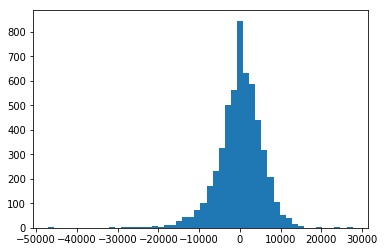

In [20]:
plt.hist(Tabla["resta"],bins=50)
plt.show()

In [21]:
resta=pd.DataFrame(Tabla["resta"])

In [22]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(resta,
                                order=(2, 0, 0),
                                seasonal_order=(1, 0, 0, 90),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6606      0.006    105.356      0.000       0.648       0.673
ar.L2          0.1007      0.007     13.715      0.000       0.086       0.115
ar.S.L90       0.0396      0.012      3.346      0.001       0.016       0.063
sigma2       1.37e+07   1.13e+05    121.569      0.000    1.35e+07    1.39e+07


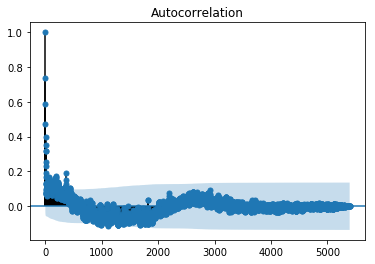

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Tabla['resta'])
plt.show()

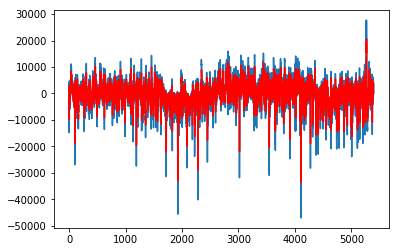

In [23]:
from statsmodels.tsa.arima_model import ARIMA
#modelarima = ARIMA(Tabla['resta'], order=(2,0,0))
#res = mod.fit()
#results = mod.fit(disp=-1)
plt.plot(Tabla['resta'])
plt.plot(results.fittedvalues, color='red')

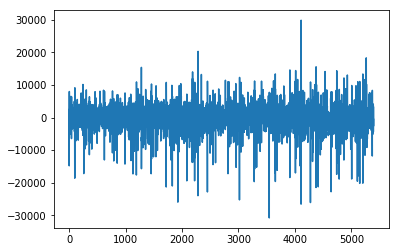

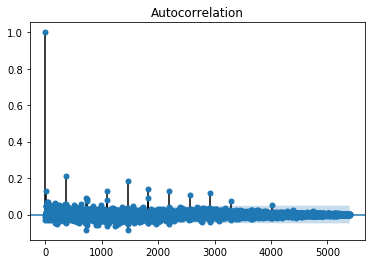

In [26]:
T=pd.DataFrame(columns=['regresion','datos','nuevo'])
T["regresion"]=results.fittedvalues
T["datos"]=Tabla['resta']
T["nuevo"]=T.datos-T.regresion
plt.plot(T.nuevo)
plot_acf(T['nuevo'])
plt.show()


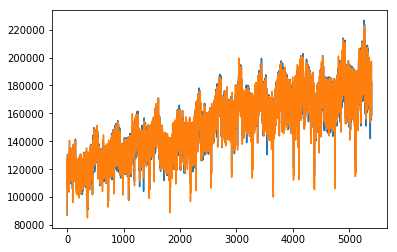

1.6150664663735548


In [27]:
plt.plot(onlyMWh.MWh[0:n].values)
plt.plot(prediction+results.fittedvalues)
#plt.axis([1630,1650,120000,160000])
plt.show()
comparacion=pd.DataFrame(columns=['real','prediccion','error'])
comparacion.real=onlyMWh.MWh[0:n].values
comparacion.prediccion=prediction+results.fittedvalues
comparacion.error=np.abs((comparacion.real.values-comparacion.prediccion)/comparacion.real)
MAPE=comparacion.error.mean()*100
print(MAPE)

### Gráfica de manera dinámica

In [68]:
import plotly.graph_objs as go
from plotly.offline import plot
data1=go.Scatter(x=dates, y=onlyMWh.MWh[0:n].values,name='REAL')
data2=go.Scatter(x=dates, y=prediction+results.fittedvalues,name='PREDICCIÓN')
fig=go.Figure(data = [data1,data2])
plot(fig)

'temp-plot.html'

In [28]:
extra=results.predict(len(onlyMWh.MWh[0:n]),len(onlyMWh.MWh[0:n])-n)
extra=extra.iloc[1:]

### todo para pronóstico

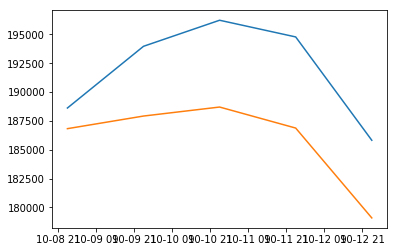

3.1156651524797323


In [29]:
Combinaciontest=kronecker(Dum_test,sencos_test)
ynew = model.predict(Combinaciontest)
comp_pronostico=pd.DataFrame(columns=['real','prediccion','error'])
comp_pronostico.real=final
comp_pronostico.prediccion=ynew-extra.values
comp_pronostico.error=np.abs((comp_pronostico.real-comp_pronostico.prediccion)/comp_pronostico.real)
MAPE=comp_pronostico.error.mean()*100
plt.plot(final)
plt.plot(comp_pronostico.prediccion)
plt.show()
print(MAPE)

In [30]:
for x in range (0,-n-1):
    if comp_pronostico.error.iloc[x] > .05:
        print (comp_pronostico.iloc[x:x+1])

In [31]:
comp_pronostico

,real,prediccion,error
fecha,,,
2018-10-09,188612.127,186821.953723,0.009491
2018-10-10,193961.508,187916.036480,0.031168
2018-10-11,196220.162,188696.170628,0.038345
2018-10-12,194773.348,186874.135330,0.040556
2018-10-13,185816.335,179085.511173,0.036223
